In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas
import tensorflow

import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)

1.3.5
2.8.0


## 데이터 불러오기

In [3]:
data_path = Path('/content/drive/MyDrive/아이펠/data') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


데이터 구성을 보면 UserId, ItemId, Rating, Time으로 구성되어 있는 것을 볼 수 있다. 여기서 Time은 UTC로 되어 있으며 1970년 1월 1일부터 경과된 초 단위 시간으로 되어 있는 것을 볼 수 있다.

# time 데이터 구성부터 다시 시작하기

In [5]:
datetime = []
for temp in data['Time']:
    datetime.append(pd.Timestamp(temp, unit='s'))

data['Time'] = datetime

Time의 형식이 UTC에서 직관적으로 알아볼 수 있는 시간단위로 변경된 것을 확인할 수 있다.

#### 학습에 사용하지 않는 데이터 제거

In [6]:
data.drop(['Rating'],axis=1,inplace=True)

In [7]:
data

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


## 데이터 전처리

### 항목별 분석

In [8]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

UserId는 6040개, 아이템 숫자는 3706개로 구성되어 있는 것을 볼 수 있다.
<br/>
여기에는 UserId는 Session으로 역할을 함

### time 데이터 범위 분석

In [9]:
data['Time'].describe()

count                 1000209
unique                 458455
top       2000-11-29 20:06:42
freq                       30
first     2000-04-25 23:05:32
last      2003-02-28 17:49:50
Name: Time, dtype: object

Time 데이터는 458455개로 구성되어 있다는 것을 볼 수 있다. 총 갯수로는 1000209개이지만 실제 데이터에는 중복된 데이터가 포함되어 있다는 것을 볼 수 있다.

### Session Length

In [10]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

User에 대한 정보(성별, 나이)알 수 없기 때문에 UserId를 사용자 행동 기준으로 분류하여 분석할 수 있다.
<br/>
즉, session length는 해당 사용자가 몇번의 액션을 취했는지를 의미한다.

In [11]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [12]:
session_length.min(), session_length.max()

(20, 2314)

In [13]:
session_length.quantile(0.999)

1343.181000000005

session length 정보길이는 보통 96~165정도 되며 99.9%가 1343 이하로 가지고 있다는 것을 볼 수 있다.

#### 길이가 가장 긴 Session length는 얼마나 있을까?

In [14]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Time
696969,4169,1268,2000-08-03 20:09:52
697168,4169,2617,2000-08-03 20:09:52
697185,4169,2628,2000-08-03 20:09:52
697219,4169,2653,2000-08-03 20:09:52
697275,4169,423,2000-08-03 20:09:52
...,...,...,...
697882,4169,3754,2002-06-15 20:52:27
695702,4169,1413,2002-06-15 21:03:51
697358,4169,494,2002-06-15 21:16:00
695945,4169,1804,2002-06-15 21:16:23


특정 user가 짧은 간격으로 여러 영화에 대해 평점을 준 것이라고 볼 수 있다. 해당 영화를 다 보고 나서 한번에 평가를 할 수도 있기 때문에 해당 데이터를 그대로 가자..

#### session length 길이 시각화

In [15]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.9]

length_percent_cumsum_999

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
395    0.897682
396    0.897848
397    0.898344
398    0.899007
399    0.899834
Length: 376, dtype: float64

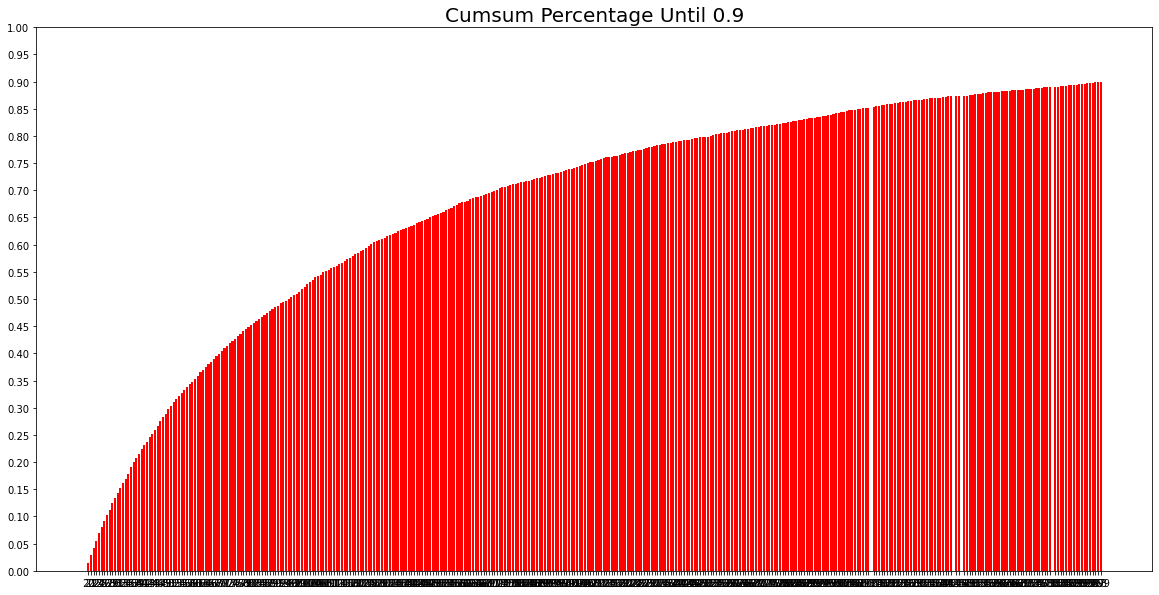

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.9', size=20)
plt.show()

### session Time

In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


총 2000년 4월부터 2003년 2월까지의 데이터로 구성되어 있다는 것을 볼 수 있음

In [18]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [19]:
# second_ago = latest - dt.timedelta(30) #가장 최근 데이터만 가져옴 
# data = data[data['Time'] > second_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

### Data Cleaning

추천 시스템 목적으로 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 데이터는 제거

In [20]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


### train, valid , test data set으로 split

시대의 콘텐츠 트렌드에 따라 사용자의 트렌드도 변경되기 때문에 기간에 따라 Train, valid, test set으로 나눈다.

In [21]:
data

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [22]:
final_time = data['Time'].max()
final_time

Timestamp('2003-02-28 17:49:50')

In [23]:
session_last_time = data.groupby('UserId')['Time'].max()
session_last_time

UserId
1      2001-01-06 23:39:11
2      2000-12-31 22:02:54
3      2000-12-31 21:35:04
4      2000-12-31 20:24:42
5      2000-12-31 07:09:45
               ...        
6036   2000-04-26 13:19:56
6037   2000-04-27 02:17:20
6038   2000-04-26 02:46:44
6039   2000-04-26 14:07:09
6040   2001-08-20 13:44:15
Name: Time, Length: 6040, dtype: datetime64[ns]

In [24]:
session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(milliseconds = 1)].index

In [25]:
session_in_train

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
           dtype='int64', name='UserId', length=6039)

In [26]:
def split_by_date(data: pd.DataFrame, n_Days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_Days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_Days)].index
    
    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    #print(before_date)
    return before_date, after_date

In [27]:
tr, test = split_by_date(data,n_Days = 90)

In [28]:
tr, val = split_by_date(tr,n_Days = 150)

In [29]:
test

,UserId,ItemId,Time
5130,36,2671,2000-12-29 03:35:55
5163,36,2250,2000-12-29 03:35:55
5313,36,2023,2000-12-29 03:35:55
5088,36,1270,2000-12-29 03:36:22
5250,36,3301,2000-12-29 03:36:47
...,...,...,...
984731,5950,3948,2003-02-27 18:13:57
984682,5950,3578,2003-02-27 18:14:30
984475,5950,3793,2003-02-27 18:15:10
984660,5950,3555,2003-02-27 18:15:37


In [30]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 844530
	 Sessions: 5653
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-02 15:40:10

* valid Set Stats Info
	 Events: 57381
	 Sessions: 154
	 Items: 3137
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 97700
	 Sessions: 233
	 Items: 3279
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [32]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

#### data pipeline 구축

In [33]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Session Dataset

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스

In [34]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each user IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [35]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
31,1,3186,2000-12-31 22:00:19,0
22,1,1270,2000-12-31 22:00:55,1
27,1,1721,2000-12-31 22:00:55,2
37,1,1022,2000-12-31 22:00:55,3
24,1,2340,2000-12-31 22:01:43,4
36,1,1836,2000-12-31 22:02:52,5
3,1,3408,2000-12-31 22:04:35,6
7,1,2804,2000-12-31 22:11:59,7
47,1,1207,2000-12-31 22:11:59,8
0,1,1193,2000-12-31 22:12:40,9


In [36]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 844066, 844189, 844530], dtype=int32)

In [37]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5650, 5651, 5652])

### Session DataLoader

RNN Cell State 초기화에 사용

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [39]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Time,item_idx
31,1,3186,2000-12-31 22:00:19,0
22,1,1270,2000-12-31 22:00:55,1
27,1,1721,2000-12-31 22:00:55,2
37,1,1022,2000-12-31 22:00:55,3
24,1,2340,2000-12-31 22:01:43,4
36,1,1836,2000-12-31 22:02:52,5
3,1,3408,2000-12-31 22:04:35,6
7,1,2804,2000-12-31 22:11:59,7
47,1,1207,2000-12-31 22:11:59,8
0,1,1193,2000-12-31 22:12:40,9


In [40]:
iter_ex = iter(tr_data_loader)

In [41]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### Modeling

Evaluation Metric 구성

In [42]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [44]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [45]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [46]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(128, 1, 3416)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               520200    
                              (128, 50)]                         
                                                                 
 dropout (Dropout)           (128, 50)                 0         
                                                                 
 dense (Dense)               (128, 3416)               174216    
                                                                 
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [47]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        print(".......")
        print(total_step)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [48]:

train_model(model, args)


Train:   0%|          | 0/6553 [00:00<?, ?it/s]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:41<07:36,  1.52s/it]


	 - Recall@20 epoch 1: 0.237907
	 - MRR@20    epoch 1: 0.060686



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.53]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:30<07:14,  1.44s/it]


	 - Recall@20 epoch 2: 0.298694
	 - MRR@20    epoch 2: 0.085243



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.49]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:26<07:06,  1.42s/it]


	 - Recall@20 epoch 3: 0.321757
	 - MRR@20    epoch 3: 0.094752



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.39] 

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:24<07:01,  1.40s/it]


	 - Recall@20 epoch 4: 0.333904
	 - MRR@20    epoch 4: 0.100628



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.99]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:23<06:59,  1.39s/it]

	 - Recall@20 epoch 5: 0.339683
	 - MRR@20    epoch 5: 0.103274



### 성능 검증

### leraning 올려서 다시 해보기
train loss가 올라갔다가 오히러 학습 진행이 될수록 내려가는 현상이 나타나 다른 방법을 활용하여 다시 학습 진행


In [49]:
args_lr = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=5, k=20)
model_lr = create_model(args)
train_model(model_lr, args)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(128, 1, 3416)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               520200    
                              (128, 50)]                         
                                                                 
 dropout_1 (Dropout)         (128, 50)                 0         
                                                                 
 dense_1 (Dense)             (128, 3416)               174216    
                                                                 
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/6553 [00:00<?, ?it/s]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:40<07:35,  1.51s/it]


	 - Recall@20 epoch 1: 0.231914
	 - MRR@20    epoch 1: 0.059536



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.41]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:29<07:11,  1.44s/it]


	 - Recall@20 epoch 2: 0.296982
	 - MRR@20    epoch 2: 0.083874



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.21]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:26<07:05,  1.41s/it]


	 - Recall@20 epoch 3: 0.322292
	 - MRR@20    epoch 3: 0.095321



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.49]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:22<06:57,  1.39s/it]


	 - Recall@20 epoch 4: 0.335135
	 - MRR@20    epoch 4: 0.101598



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.04]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:23<06:59,  1.39s/it]

	 - Recall@20 epoch 5: 0.343161
	 - MRR@20    epoch 5: 0.105194



### Drop_out 변경해서 Train
이전 모델에 비해 정확도가 올라갔지만 loss는 변화가 거의 없는 현상이 나타나 dropout 수정하여 다시 실행

In [50]:
args_drop = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.01, epochs=5, k=20)
model_drop = create_model(args)
train_model(model_drop, args)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(128, 1, 3416)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               520200    
                              (128, 50)]                         
                                                                 
 dropout_2 (Dropout)         (128, 50)                 0         
                                                                 
 dense_2 (Dense)             (128, 3416)               174216    
                                                                 
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/6553 [00:00<?, ?it/s]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:38<07:30,  1.50s/it]


	 - Recall@20 epoch 1: 0.236462
	 - MRR@20    epoch 1: 0.061035



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.48]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:29<07:11,  1.43s/it]


	 - Recall@20 epoch 2: 0.296661
	 - MRR@20    epoch 2: 0.084421



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.25]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:25<07:03,  1.41s/it]


	 - Recall@20 epoch 3: 0.321169
	 - MRR@20    epoch 3: 0.095443



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.14]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:23<07:00,  1.40s/it]


	 - Recall@20 epoch 4: 0.333637
	 - MRR@20    epoch 4: 0.101343



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.1] 

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:25<07:02,  1.40s/it]

	 - Recall@20 epoch 5: 0.340539
	 - MRR@20    epoch 5: 0.103645



### batch size 변경
dropput 수정으로 accuracy와 loss가 많이 개선되었음. 마지막으로 batch size 조정헤보기

In [51]:
args_batch = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.01, epochs=5, k=20)
model_batch= create_model(args)
train_model(model_batch, args)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(128, 1, 3416)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               520200    
                              (128, 50)]                         
                                                                 
 dropout_3 (Dropout)         (128, 50)                 0         
                                                                 
 dense_3 (Dense)             (128, 3416)               174216    
                                                                 
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/6553 [00:00<?, ?it/s]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:38<07:31,  1.50s/it]


	 - Recall@20 epoch 1: 0.234107
	 - MRR@20    epoch 1: 0.061577



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.49]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:30<07:14,  1.44s/it]


	 - Recall@20 epoch 2: 0.301851
	 - MRR@20    epoch 2: 0.085910



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.15]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:26<07:05,  1.41s/it]


	 - Recall@20 epoch 3: 0.326680
	 - MRR@20    epoch 3: 0.097099



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.47]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:23<07:00,  1.40s/it]


	 - Recall@20 epoch 4: 0.338988
	 - MRR@20    epoch 4: 0.102516



Train:   0%|          | 0/6553 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.96]

.......
838877


Evaluation:  33%|███▎      | 146/447 [03:22<06:57,  1.39s/it]

	 - Recall@20 epoch 5: 0.343054
	 - MRR@20    epoch 5: 0.105503



## Model 평가하기

In [52]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")


In [53]:
test_model(model, args, test)

Evaluation:  57%|█████▋    | 431/761 [10:23<07:57,  1.45s/it]

	 - Recall@20: 0.289951
	 - MRR@20: 0.083740



In [54]:
test_model(model_lr, args_lr, test)

Evaluation:  57%|█████▋    | 431/761 [10:23<07:57,  1.45s/it]

	 - Recall@20: 0.289769
	 - MRR@20: 0.083986



In [55]:
test_model(model_drop, args_drop, test)

Evaluation:  57%|█████▋    | 431/761 [10:21<07:55,  1.44s/it]

	 - Recall@20: 0.289026
	 - MRR@20: 0.084849



### 회고
처음 Time 시간대가 UTC로 표기되어 있어 학습 진행에 힘들어 datetime으로 변경해주는 작업하여 실행하였지만 알수 없는 오류 발생으로 생각보다 작업이 오래걸렸다. 해당 오류를 수정하기 위해 다양한 방법으로 변경하거나 환경을 바꿔보았지만 그래도 수정되지 않아 새로 환경을 구성하여 실행하였다.
<br/>
처음 arg로 설정한 결과에 비해 learning rate와 dropout 범위를 조정한 값이 조금 더 좋은 결과가 나타났다.
하지만 최종 평가지표를 확인해보면 학습 결과에 비해 MRR@k과 Recall@k 값이 크게 변화되지 않았다.
<br/>
추천 시스템에서는 정확도도 중요하지만 얼만큼 사용자의 취향에 맞는 물품이나 컨텐츠를 순서에 맞게 추천해주는냐도 중요하다.
<br/>
최종적인 평가지표를 높이기 위해서는 정확도를 조금 더 높이기 위해 arg tuning 뿐만 아니라 데이터도 더 필요할 것 같다.
<br/>
